### Final Project

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report
from ISLP import load_data
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

np.random.seed(2)
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor

### Import Datasets

In [2]:
# Load the dataset
phishingurl_data = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [3]:
# Load the New dataset
new_safe_urls = pd.read_csv("SafeURLs.csv")

In [4]:
# New phishing dataset requires extra processing
import csv

def process_urls(input_csv):
    # Read the input CSV file
    with open(input_csv, mode='r', newline='', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header row
        urls = [row[0] for row in reader]

    # Split URLs by pipe and remove duplicates
    unique_urls = set()
    for url in urls:
        parts = url.split('|')
        for part in parts:
            cleaned_url = part.strip()
            if cleaned_url:
                unique_urls.add(cleaned_url)

    return list(unique_urls)

new_phish_urls = process_urls("phishingURLs.csv")

### Process the URLs

In [5]:
import re
from urllib.parse import urlparse

def analyze_url(url, label):
    # Parse the URL
    parsed_url = urlparse(url)
    
    # Calculate length
    url_length = len(url)
    
    # Count letters, digits, and special characters
    num_letters = sum(c.isalpha() for c in url)
    num_digits = sum(c.isdigit() for c in url)
    num_equals = url.count('=')
    num_question_marks = url.count('?')
    num_ampersands = url.count('&')
    
    # Count periods, ignoring the first two
    num_periods = max(0, url.count('.') - 2)
    
    # Count special characters excluding slashes and periods
    num_special_chars = sum(not c.isalnum() and c not in ('/', '.') for c in url) - (num_equals + num_question_marks + num_ampersands) + num_periods
    
    # Extract domain and TLD
    domain = parsed_url.netloc
    tld = domain.split('.')[-1] if '.' in domain else ''
    domain_length = len(domain)
    
    # Check if URL uses HTTPS
    has_https = parsed_url.scheme == 'https'
    
    # Populate dictionary
    url_analysis = {
        'URL': url,
        'URLLength': url_length,
        'NoOfLettersInURL': num_letters,
        'NoOfDegitsInURL': num_digits,
        'Domain': domain,
        'TLD': tld,
        'DomainLength': domain_length,
        'NoOfEqualsInURL': num_equals,
        'NoOfQMarkInURL': num_question_marks,
        'NoOfAmpersandInURL': num_ampersands,
        'NoOfOtherSpecialCharsInURL': num_special_chars,
        'IsHTTPs': has_https,
        'label': label
    }
    
    return url_analysis

results = []

# process safe urls
for index, row in new_safe_urls.iterrows():
    url_analysis = analyze_url(row['URL'], 1)
    results.append(url_analysis)

print(len(results))    

# process phishing urls
for url in new_phish_urls:
    url_analysis = analyze_url(url, 0)
    results.append(url_analysis)
    
print(len(results))

new_urls = pd.DataFrame(results)

3218
5204


In [6]:
new_urls.tail()

,URL,URLLength,NoOfLettersInURL,NoOfDegitsInURL,Domain,TLD,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,IsHTTPs,label
5199,https://doctorsofnursingpractice31.ebtrk6.com/...,175,57,99,doctorsofnursingpractice31.ebtrk6.com,com,37,6,1,5,2,True,0
5200,https://www.google.fr/amp/s/www.google.com%2Fu...,422,257,112,www.google.fr,fr,13,2,0,0,44,True,0
5201,https://doctorsofnursingpractice1.ebtrk6.com/u...,157,58,82,doctorsofnursingpractice1.ebtrk6.com,com,36,5,1,4,2,True,0
5202,https://doctorsofnursingpractice1.ebtrk6.com/o...,154,55,82,doctorsofnursingpractice1.ebtrk6.com,com,36,5,1,4,2,True,0
5203,https://lh4.googleusercontent.com/YRMs4_VrZ67k...,170,144,17,lh4.googleusercontent.com,com,25,0,0,0,4,True,0


### Split the Datasets

In [7]:
# There are too many records for these scripts to run in a reasonable amount of time
# So, we take a random sample of 5000 records
url_sample = phishingurl_data.sample(5000, random_state=13)

# Set index equal to the domain field
url_sample.set_index('URL', inplace=True)

# Drop text fields: Filename, URL, TLD, Title
url_sample_data = url_sample.drop(['Domain', 'TLD', 'Title'],axis = 1)

In [8]:
url_sample_data = url_sample[['URLLength', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'label']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(url_sample_data.drop('label',axis = 1)
                                                    , url_sample_data['label']
                                                    , test_size=0.3, random_state=13)

In [9]:
new_sample = new_urls[['URLLength', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'label']]

# Split data into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_sample.drop('label',axis = 1)
                                                    , new_sample['label']
                                                    , test_size=0.3, random_state=13)

In [10]:
# Check the Mean
url_sample_data.mean()

URLLength                     34.1652
NoOfLettersInURL              19.1008
NoOfDegitsInURL                1.8476
NoOfEqualsInURL                0.0576
NoOfQMarkInURL                 0.0268
NoOfAmpersandInURL             0.0282
NoOfOtherSpecialCharsInURL     2.2858
label                          0.5806
dtype: float64

In [11]:
# Check the Mean
new_sample.mean()

URLLength                     159.626826
NoOfLettersInURL              113.398155
NoOfDegitsInURL                29.563605
NoOfEqualsInURL                 1.696387
NoOfQMarkInURL                  0.492890
NoOfAmpersandInURL              1.165450
NoOfOtherSpecialCharsInURL      6.665642
label                           0.618370
dtype: float64

In [12]:
# Check the Variance
url_sample_data.var()

URLLength                     963.999109
NoOfLettersInURL              505.402920
NoOfDegitsInURL                55.030580
NoOfEqualsInURL                 0.308344
NoOfQMarkInURL                  0.034889
NoOfAmpersandInURL              0.386282
NoOfOtherSpecialCharsInURL      7.612841
label                           0.243552
dtype: float64

In [13]:
# Check the Variance
new_sample.var()

URLLength                     35095.559734
NoOfLettersInURL              22039.684225
NoOfDegitsInURL                1559.368431
NoOfEqualsInURL                   6.635459
NoOfQMarkInURL                    0.287284
NoOfAmpersandInURL                4.767739
NoOfOtherSpecialCharsInURL       63.466119
label                             0.236034
dtype: float64

### Linear Logistic Regression

In [14]:
# Fit linear regression model on train set
model = LogisticRegression(solver='liblinear', random_state=0)
lfit = model.fit(X_train, y_train)

# Predict on test set and calculate accuracy
lpred = lfit.predict(X_test)
acc_score = accuracy_score(lpred , y_test)

print("Accuracy: ",acc_score)

Accuracy:  0.908


In [15]:
# Current model prediction on new dataset
# Predict on test set and calculate accuracy
lpred = lfit.predict(X_test2)
acc_score = accuracy_score(lpred , y_test2)

print("Accuracy: ",acc_score)

Accuracy:  0.39308578745198464


In [16]:
# Using new dataset

# Fit linear regression model on train set
model = LogisticRegression(solver='liblinear', random_state=0)
lfit = model.fit(X_train2, y_train2)

# Predict on test set and calculate accuracy
lpred = lfit.predict(X_test2)
acc_score = accuracy_score(lpred , y_test2)

print("Accuracy: ",acc_score)

Accuracy:  0.7906530089628682


### Decision Trees

In [17]:
# fit decision tree model
tree_phishing = DecisionTreeClassifier()
tree_phishing.fit(X_train, y_train)

DecisionTreeClassifier()

In [18]:
tree_summary = export_text(tree_phishing, feature_names=X_train.columns.tolist())
print(tree_summary)

|--- NoOfOtherSpecialCharsInURL <= 2.50
|   |--- NoOfDegitsInURL <= 0.50
|   |   |--- NoOfOtherSpecialCharsInURL <= 1.50
|   |   |   |--- URLLength <= 24.50
|   |   |   |   |--- NoOfLettersInURL <= 11.50
|   |   |   |   |   |--- URLLength <= 23.50
|   |   |   |   |   |   |--- NoOfLettersInURL <= 10.50
|   |   |   |   |   |   |   |--- URLLength <= 22.50
|   |   |   |   |   |   |   |   |--- NoOfLettersInURL <= 9.50
|   |   |   |   |   |   |   |   |   |--- URLLength <= 21.50
|   |   |   |   |   |   |   |   |   |   |--- NoOfLettersInURL <= 8.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- NoOfLettersInURL >  8.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- URLLength >  21.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- NoOfLettersInURL >  9.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |

## SVM

In [20]:
# train svm
from sklearn.svm import SVC
scaler = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

# grid search with SVC
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train2_scaled, y_train2)

print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.845 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.861 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.857 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.860 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.830 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.797 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.824 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.832 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.799 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.775 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [21]:
# predict on test data
tree_pred = tree_phishing.predict(X_test)

# create confusion matrix
confusion_matrix = pd.crosstab(index=tree_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

classification_report(y_test, tree_pred)

label    0    1
               
0      604   13
1       21  862


'              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.97       625\n           1       0.98      0.99      0.98       875\n\n    accuracy                           0.98      1500\n   macro avg       0.98      0.98      0.98      1500\nweighted avg       0.98      0.98      0.98      1500\n'

In [22]:
# predict on test data
tree_pred = tree_phishing.predict(X_test2)

# create confusion matrix
confusion_matrix = pd.crosstab(index=tree_pred, columns=y_test2, rownames=[''])
print(confusion_matrix)

classification_report(y_test2, tree_pred)

label    0    1
               
0      604  905
1        8   45


'              precision    recall  f1-score   support\n\n           0       0.40      0.99      0.57       612\n           1       0.85      0.05      0.09       950\n\n    accuracy                           0.42      1562\n   macro avg       0.62      0.52      0.33      1562\nweighted avg       0.67      0.42      0.28      1562\n'

In [26]:
svm_pred2 = grid.best_estimator_.predict(X_test2_scaled)

# create confusion matrix
confusion_matrix = pd.crosstab(index=svm_pred2, columns=y_test2, rownames=[''])
print(confusion_matrix)
print((458 + 906) / (458 + 906 + 44 + 154))
print(classification_report(y_test2, svm_pred2))

label    0    1
               
0      458   44
1      154  906
0.8732394366197183
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       612
           1       0.85      0.95      0.90       950

    accuracy                           0.87      1562
   macro avg       0.88      0.85      0.86      1562
weighted avg       0.88      0.87      0.87      1562



In [44]:
# fit decision tree model
tree_phishing2 = DecisionTreeClassifier()
tree_phishing2.fit(X_train2, y_train2)

DecisionTreeClassifier()

In [45]:
# predict on test data
tree_pred2 = tree_phishing2.predict(X_test2)

# create confusion matrix
confusion_matrix = pd.crosstab(index=tree_pred2, columns=y_test2, rownames=[''])
print(confusion_matrix)

print(classification_report(y_test2, tree_pred2))

label    0    1
               
0      508  110
1      104  840
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       612
           1       0.89      0.88      0.89       950

    accuracy                           0.86      1562
   macro avg       0.86      0.86      0.86      1562
weighted avg       0.86      0.86      0.86      1562



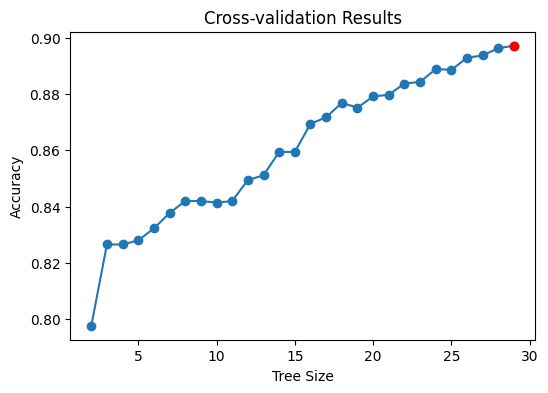

In [46]:
# fit decision tree model
tree_phishing = DecisionTreeClassifier(random_state=7)
tree_phishing.fit(X_train, y_train)

# cross-validation to determine optimal tree size
params = {'max_leaf_nodes': range(2, 30)}  
cv_phishing = GridSearchCV(tree_phishing, params, cv=10)
cv_phishing.fit(X_train, y_train)
cv_results = cv_phishing.cv_results_

# find the best score for max leaf nodes
best_size = cv_phishing.best_params_['max_leaf_nodes']
best_score = cv_phishing.best_score_

# plot results of cross-validation
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');

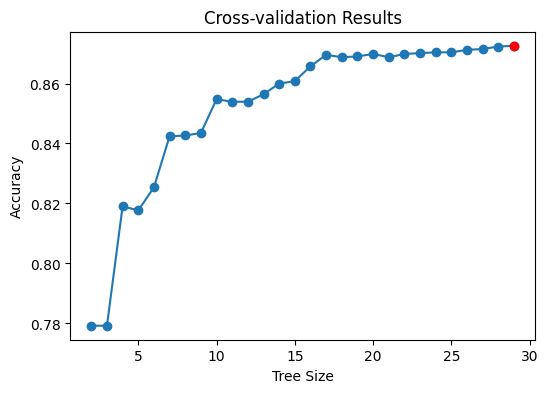

In [47]:
# fit decision tree model
tree_phishing = DecisionTreeClassifier(random_state=7)
tree_phishing.fit(X_train2, y_train2)

# cross-validation to determine optimal tree size
params = {'max_leaf_nodes': range(2, 30)}  
cv_phishing = GridSearchCV(tree_phishing, params, cv=10)
cv_phishing.fit(X_train2, y_train2)
cv_results = cv_phishing.cv_results_

# find the best score for max leaf nodes
best_size = cv_phishing.best_params_['max_leaf_nodes']
best_score = cv_phishing.best_score_

# plot results of cross-validation
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');